# 1. Data Collection

We are using multiple datasets to make larger dataset that is balanced (males/females/Hijab/non-hijab). In this notebook I will work on Hijab dataset that is 112 image (The best we could find).

In [1]:
import sys
#   sys.path.append("path/to/UTILITY SCRIPTS/utility")

sys.path.append("/home/seif_elkerdany/projects/Attendance_System/modeling/utility")

In [2]:
#   from utility.utility import datacleaner

In [2]:
from utility import datacleaner

# 1.2 Data Exploration

### 1.Hijab dataset 
We went to look for hijab dataset because the first dataset has few hijab images or not at all.
So we need to cure the imbalance and this biased model. We found small dataset but we need to check it first.

In [3]:
# HIJAB_PATH = "/kaggle/input/women-faces-with-hijabscientific-use-only"
HIJAB_PATH = "/home/seif_elkerdany/projects/Dataset/Hijab"

In [4]:
# Checking the extentions in the dataset
non_jpg = datacleaner.extention_checker(HIJAB_PATH)

100%|██████████| 112/112 [00:00<00:00, 210844.73it/s]

Number of JPG images found: 112
Number of non-JPG images found: 0


### We check for the extentions and now we need to check for the quality of the dataset. We can plot some random sample of 10 images.

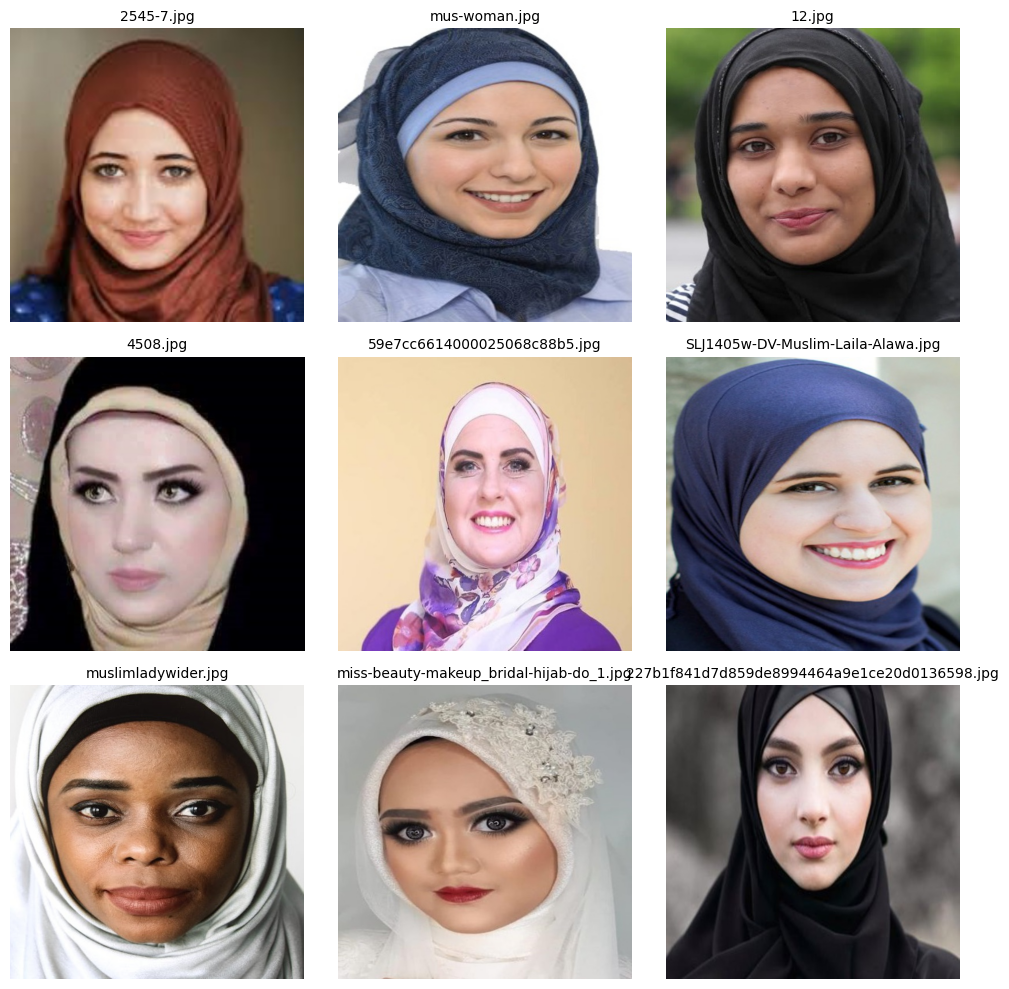

In [5]:
datacleaner.sample_plot(HIJAB_PATH)

### As you can see their are images with high blur, we can try to fix these images in the preprocessing section.

#### Checking for the blurry images and the sharpest images.

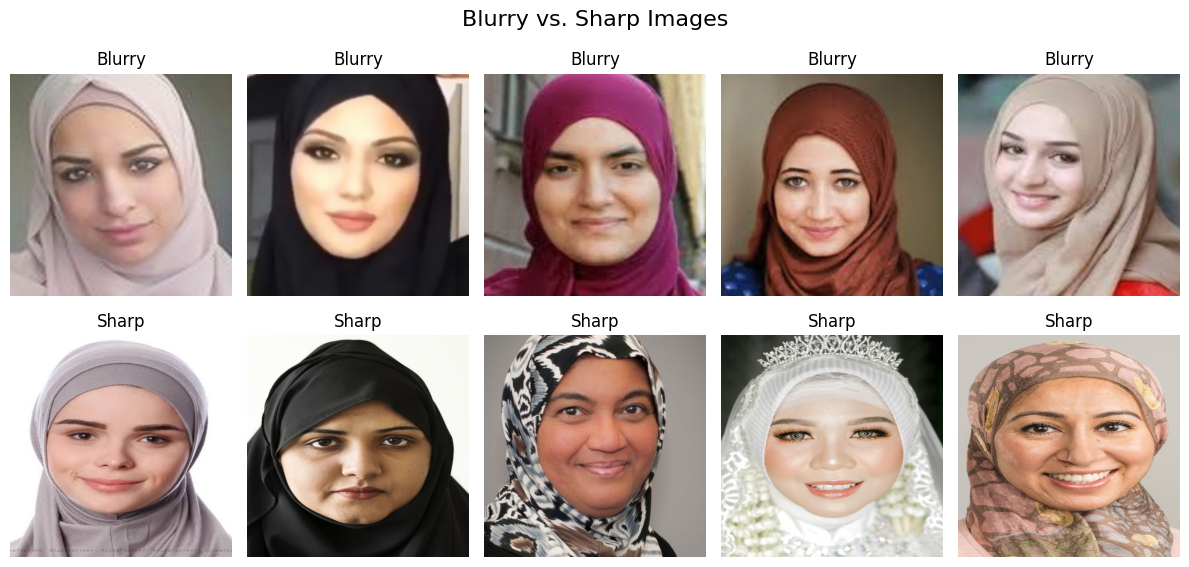

In [6]:
blurry, sharpe = datacleaner.check_blur_in_folder(HIJAB_PATH)

The blurred images aren't that bad we can apply sharpning kernel to sharpen the image more.

In [7]:
# Warning! uncomment el cell dy lma nigy n run locally 3l4an kaggle msh bism7 b ms7 el swr mn folder el data el asly
import os

# After taking a look on the data these two images are low resolution and has too many problems
os.remove(HIJAB_PATH + "/712327_2607224_book_magazine.jpg")
os.remove(HIJAB_PATH + "/a9cae86f6bd5181f62d70c0df9b5df62.jpg")

### In this dataset I need to check the size of the images in it.

In [8]:
import cv2
from collections import Counter

def check_image_sizes(folder_path):
    sizes = []
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file) 
        img = cv2.imread(img_path) 
        if img is not None:
            sizes.append(img.shape[:2])  # (Height, Width)

    print("Image size distribution:", Counter(sizes)) 

In [9]:
check_image_sizes(HIJAB_PATH)

Image size distribution: Counter({(512, 512): 110})


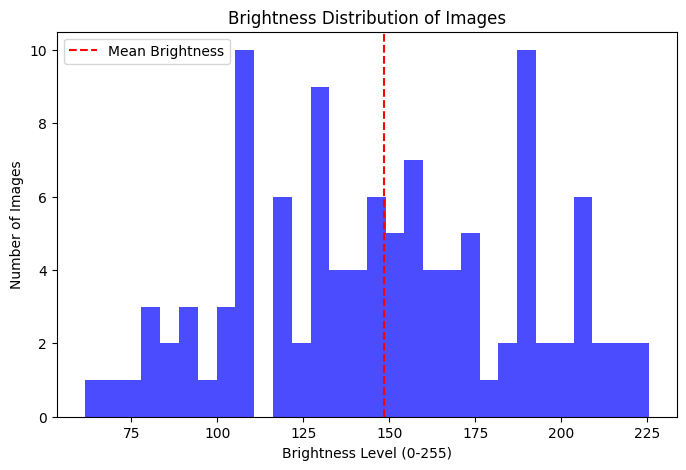

In [10]:
bright_images = datacleaner.check_brightness_in_folder(HIJAB_PATH)

In [11]:
datacleaner.process_and_overwrite_images(HIJAB_PATH)

100%|██████████| 110/110 [00:00<00:00, 318.12it/s]


## **Problem**
The dataset does not contain any identity labels, meaning we do not know which images belong to the same person. This presents a challenge because traditional Siamese networks rely on labeled "same-person" and "different-person" pairs.

## **Solution**
Since explicit identity labels are unavailable, we can generate meaningful pairs using the following strategies:

### **Synthetic Positive Pairs (Using Augmentation)**
- Instead of relying on identity, we assume that an augmented version of an image is a "similar" image.
- We apply transformations such as:
  - Random Rotation
  - Horizontal Flip
- This allows us to generate **positive pairs (label=1)** without identity labels.

In [12]:
import os
import random
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm

# Define strong image augmentation for synthetic positive pairs
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(20),  # Rotate by ±20 degrees
    transforms.RandomHorizontalFlip(0.7),  # Flip horizontally
])

def apply_augmentation(image_path, save_path):
    """
    Applies augmentation to an image and saves it.
    
    Args:
        image_path (str): Original image path.
        save_path (str): Path to save the augmented image.
    """
    image = Image.open(image_path).convert("L")  
    augmented_image = augmentation_transform(image) 
    augmented_image.save(save_path) 

def create_siamese_csv(image_folder, csv_filename="siamese_dataset.csv", num_pairs=1000):
    """
    Creates a dataset of image pairs for a Siamese Network.
    
    - Uses synthetic positive pairs (augmented images).
    - Ensures equal positive and negative pairs.

    Args:
        image_folder (str): Folder containing images.
        csv_filename (str): Output CSV filename.
        num_pairs (int): Number of image pairs to generate.
    """
    
    image_list = [img for img in os.listdir(image_folder) if img.lower().endswith(".jpg")]
    
    if len(image_list) < 2:
        print("Error: Not enough images to create pairs!")
        return

    data = []  # Store generated pairs
    num_positive = num_pairs // 2  # 50% positive pairs
    num_negative = num_pairs // 2  # 50% negative pairs

    # ----------- Generate Positive Pairs -----------
    for _ in tqdm(range(num_positive)):
        img1 = random.choice(image_list)  # Select random image
        img1_path = os.path.join(image_folder, img1)

        # Create an augmented version 
        aug_img_name = f"aug_{img1.replace(' ', '_')}"  
        aug_img_path = os.path.join(image_folder, aug_img_name)

        apply_augmentation(img1_path, aug_img_path)  

        # Save as a positive pair
        data.append([img1_path, aug_img_path, 1])  # Label = 1

    # ----------- Generate Negative Pairs -----------
    for _ in tqdm(range(num_negative)):
        img1, img2 = random.sample(image_list, 2)  # Pick two different images
        img1_path = os.path.join(image_folder, img1)
        img2_path = os.path.join(image_folder, img2)

        data.append([img1_path, img2_path, 0])  # Label = 0

    # Convert list to DataFrame and save to CSV
    df = pd.DataFrame(data, columns=["image1", "image2", "label"])
    df.to_csv(csv_filename, index=False)

    print(f"✅ CSV file saved at {csv_filename} with {len(df)} pairs.")

csv_filename = "siamese_dataset.csv"

create_siamese_csv(HIJAB_PATH, csv_filename)

100%|██████████| 500/500 [00:00<00:00, 504001.92it/s]

✅ CSV file saved at siamese_dataset.csv with 1000 pairs.
